# NBA All Star Predictions

## Prerequisites

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
from collections import defaultdict
import requests
from unidecode import unidecode
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
import matplotlib.pyplot as plt
import seaborn as sns

models = []

In [ ]:
team_table_page = requests.get('https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations')
soup = BeautifulSoup(team_table_page.text)
team_abbr = {}
for row in soup.find_all('tr'):
    entries = row.find_all('td')
    team_abbr[entries[1].text.strip()] = entries[0].text.strip()
    
team_abbr

## Scraping Data from basketball-reference

In [ ]:
# get all season win pcts since 1995
wins = {}
for year in range(2000, 2021):
    team_wins = {}
    win_html = requests.get("https://www.basketball-reference.com/leagues/NBA_2020.html").text
    bs = BeautifulSoup(win_html)
    tbls = bs.find_all('table')
    east = tbls[0]
    west = tbls[1]

    for row in east.find_all('tr'):
        head = row.find_all('th')
        data = row.find_all('td')
        if (len(data) > 0):
            team_name = team_abbr[head[0].text.replace('*', '')]
            win_perc = float(data[2].text)
            team_wins[team_name] = win_perc

    for row in west.find_all('tr'):
        head = row.find_all('th')
        data = row.find_all('td')
        if (len(data) > 0):
            team_name = team_abbr[head[0].text.replace('*', '')]
            win_perc = float(data[2].text)
            team_wins[team_name] = win_perc
    
    wins[year] = team_wins
    

In [ ]:
# Function for getting player team win pct from an nba_df row
def get_team_pct(year, row):
    if team == 'TOT'
    return wins[year][row['Tm']]

In [2]:
# borrowed from medium post https://towardsdatascience.com/using-machine-learning-to-predict-nba-all-stars-part-1-data-collection-9fb94d386530
# i changed the way that data was collected mapping year -> all star instead of the other way around
# this dictionary will map year to players in all star game
# selected for an all-star game, either initially or as a replacement
all_star_appearances = defaultdict(list)

# rows to ignore when iterating the roster tables
ignore_fields = set(['Team Totals', 'Reserves'])

START_YEAR, END_YEAR = 2000, 2021

# unidecode doesn't catch the accented c in Peja's last name (Stojakovic), fix it
# also overwrite any instance of Metta World Peace to Ron Artest
def fix_name(full_name):
    first_name = full_name.split(' ')[0]
    if first_name == 'Peja':
        return 'Peja Stojakovic'
    elif first_name == 'Metta':
        return 'Ron Artest'
    else:
        return unidecode(full_name)

for year in range(START_YEAR, END_YEAR):

    # no ASG played in 1|999 because of the lockout
    if year == 1999:
        continue

    print('Scraping ASG {} data...'.format(year))

    # will store all the all-stars for this year
    all_stars = set([])

    html = requests.get('https://www.basketball-reference.com/allstar/NBA_{}.html'.format(year)).content
    soup = BeautifulSoup(html, 'html.parser')

    # this part was annoying - back when ASG was always East vs. West, the tables 
    # were encoded with id="East"/id="West" so they could be extracted more easily/reliably
    # but now, you have games like Giannis vs. LeBron and the table id's are different, so I 
    # had to extract them by index, which is unreliable in the event that the site's design 
    # changes in the future

    # gets rosters for team 1 and team 2
    s1, s2 = soup.findAll('table')[1:3]

    df1 = pd.read_html(str(s1))[0]
    df2 = pd.read_html(str(s2))[0]

    # get the all-stars from teams 1 and 2
    for df in [df1, df2]:
        for i, row in df.iterrows():
            if pd.notnull(row[0]) and row[0] not in ignore_fields:
                player = row[0]
                all_stars.add(fix_name(player))

    # gets all li elements in the page
    s3 = soup.findAll('li') 

    # finds the li element that contains the data pertaining to injury related selections 
    # - players who were selected but couldn't participate due to injury,
    # and their respective replacements
    #
    # since all_stars is a hashset, we don't need to worry about accidentally double counting an all-star
    for s in s3:
        if 'Did not play' in str(s):
            for player in [name.get_text() for name in s.findAll('a')]: # all the injured players and their replacements
                all_stars.add(fix_name(player))
            break

    # update the appearances dictionary
    for player in all_stars:
        all_star_appearances[year].append(player)



Scraping ASG 2000 data...
Scraping ASG 2001 data...
Scraping ASG 2002 data...
Scraping ASG 2003 data...
Scraping ASG 2004 data...
Scraping ASG 2005 data...
Scraping ASG 2006 data...
Scraping ASG 2007 data...
Scraping ASG 2008 data...
Scraping ASG 2009 data...
Scraping ASG 2010 data...
Scraping ASG 2011 data...
Scraping ASG 2012 data...
Scraping ASG 2013 data...
Scraping ASG 2014 data...
Scraping ASG 2015 data...
Scraping ASG 2016 data...
Scraping ASG 2017 data...
Scraping ASG 2018 data...
Scraping ASG 2019 data...
Scraping ASG 2020 data...


In [ ]:
all_star_appearances[2020]

In [3]:

def get_nba_df(year):
    df = pd.read_html("https://www.basketball-reference.com/leagues/NBA_"+str(year)+"_per_game.html")[0]

    adv_df = pd.read_html("https://www.basketball-reference.com/leagues/NBA_"+str(year)+"_advanced.html")[0]
    df = df.combine_first(adv_df)
    df = df.astype('string')
    is_tot = df['Tm']=='TOT'
    traded_players = df[is_tot]['Player']
    # dont record half-seasons of traded players, only total seasons ("TOT")
    

    df = df.query('not (Player in @traded_players & Tm != "TOT")')
    df.fillna("0", inplace=True)
    df.replace(r'^\s*$', "0", regex=True, inplace=True)
    # filter out header values
    df = df[(df['2P'] != "2P")]
    df = df[(df['PF'] != "PF")]
    df = df.astype({'Pos': 'string', '2P': 'float', '2PA': 'float', '3P': 'float', '3P%': 'float', '3PA': 'float', '3PAr': 'float', 'AST': 'float',
                    'AST%': 'float', 'Age': 'int', 'BLK': 'float', 'BLK%': 'float', 'BPM': 'float', 'DBPM': 'float', 
                    'DRB': 'float', 'DRB%': 'float', 'DWS': 'float', 'FG': 'float', 'FG%': 'float', 'FGA': 'float',
                    'FT': 'float', 'FT%': 'float', 'FTA': 'float', 'FTr': 'float', 'G': 'int', 'GS': 'int', 'MP': 'float', 
                    'OBPM': 'float', 'ORB': 'float', 'ORB%': 'float', 'OWS': 'float', 'PER': 'float', 'PF': 'float', 'PTS': 'float','Rk': 'float', 'STL': 'float', 'STL%': 'float', 'TOV': 'float', 'TOV%': 'float', 
                    'TRB': 'float', 'TRB%': 'float', 'TS%': 'float', 'USG%': 'float', 'WS': 'float', 'eFG%': 'float', 'VORP': 'float'})
    df['Player'] = df['Player'].apply(fix_name)
    return df

In [4]:


year_dfs = []
for year in range(2000, 2021):
    df = get_nba_df(year)
    # Add all star field
    as_data = []

    for player in all_star_appearances[year]:
        as_data.append([player, True])
        
        
    as_df = pd.DataFrame(as_data, columns=['Player', 'All_Star'])
    df = pd.merge(df, as_df, left_on='Player', right_on='Player', how='left')
    df = df.astype({'All_Star': 'boolean'})
    df['All_Star'] = df['All_Star'].fillna(False)
    
    
    year_dfs.append(df)
    



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anacon

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anacon

In [5]:
#Get final data by concatenating all years
final = pd.concat(year_dfs)
final.reset_index(drop=True)
# Save final data
final.to_csv('data/All_Star_Data.csv')

In [47]:
#Read from csv if necessary
final = pd.read_csv('data/All_Star_Data.csv')

final[final['All_Star']==True]['GS'].quantile(0.01)


38.15

## Generate Models

## Analysis of Predictors

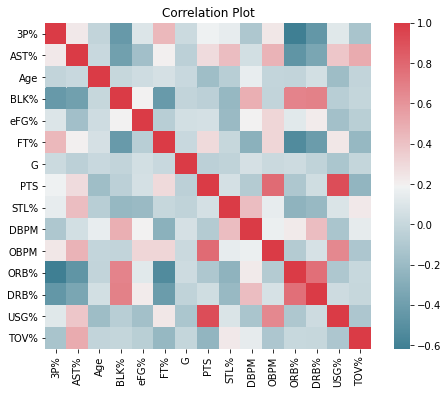

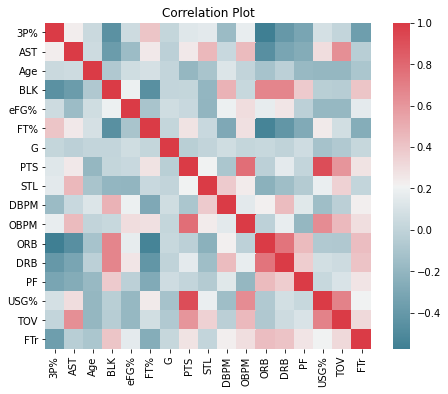

In [48]:

# Choosing to separate percentages and per games here for some stats due to high degree of correlation
# Only players with a large number of games started and minutes
final = final.query('GS > 38.15 & MP > 29.415')

stats_pct = ['3P%', 'AST%', 'Age', 'BLK%', 'eFG%', 'FT%', 
                    'G', 'PTS', 'STL%', 'DBPM', 'OBPM',
                    'ORB%', 'DRB%', 'USG%', 'TOV%']
# and the per game numbers
stats_pg = ['3P%', 'AST', 'Age', 'BLK', 'eFG%', 'FT%', 
                    'G',  'PTS', 'STL', 'DBPM', 
                  'OBPM', 'ORB', 'DRB', 'PF',  'USG%', 'TOV', 'FTr']
x = final[stats_pct]
y = final['All_Star']
y = np.asarray(y,dtype=np.bool)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4)

x_pg = final[stats_pg]
x_pg_train, x_pg_test, y_pg_train, y_pg_test = train_test_split(x_pg, y, test_size=0.4)

# Check predictor correlation 
cor = x_train.corr(method='pearson')
ig, ax = plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

# Check PG predictor correlation
cor = x_pg_train.corr(method='pearson')
ig, ax = plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [49]:
# Different sampling techniques to attempt to correct for the imbalance in all stars vs non all stars
fs = 0
ts = 0
for y in y_train:
    if y:
        ts += 1
    else:
        fs += 1
        
print("all star to non all star ratio:" + str(ts/fs))
sm = RandomUnderSampler(sampling_strategy=0.25)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_pg_train, y_pg_train = sm.fit_resample(x_pg_train, y_pg_train)
fs = 0
ts = 0
for y in y_train:
    if y:
        ts += 1
    else:
        fs += 1
        
print("all star to non all star ratio:" + str(ts/fs))

all star to non all star ratio:0.2567849686847599


ValueError: The specified ratio required to generate new sample in the majority class while trying to remove samples. Please increase the ratio.

In [14]:
fs = 0
ts = 0
for y in y_train:
    if y:
        ts += 1
    else:
        fs += 1
        
print("all star to non all star ratio:" + str(ts/fs))

os = SMOTE(sampling_strategy=1)
x_train, y_train = os.fit_resample(x_train, y_train)
x_pg_train, y_pg_train = os.fit_resample(x_pg_train, y_pg_train)

fs = 0
ts = 0
for y in y_train:
    if y:
        ts += 1
    else:
        fs += 1
        
print("all star to non all star ratio:" + str(ts/fs))

all star to non all star ratio:0.1716826265389877
all star to non all star ratio:1.0


In [ ]:
# best params found so far for linear regression from GridSearchCV
best_params = {'C': 10, 'class_weight': {0: 0.37311557788944727, 1: 0.6268844221105527}}

## Logistic Regression

In [50]:
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_train, y_train)
predict = logisticRegr.predict(x_test)
print(classification_report(y_test, predict))

models.append(["LogisticRegression_Pct", logisticRegr])

# per game stats version
logisticRegr = LogisticRegression(max_iter=100000)
logisticRegr.fit(x_pg_train, y_pg_train)
predict = logisticRegr.predict(x_pg_test)
print(classification_report(y_pg_test, predict))

models.append(["LogisticRegression_PG", logisticRegr])

              precision    recall  f1-score   support

       False       0.85      0.95      0.90       642
        True       0.62      0.36      0.45       162

    accuracy                           0.83       804
   macro avg       0.74      0.65      0.68       804
weighted avg       0.81      0.83      0.81       804

              precision    recall  f1-score   support

       False       0.86      0.95      0.91       643
        True       0.67      0.40      0.50       161

    accuracy                           0.84       804
   macro avg       0.77      0.67      0.70       804
weighted avg       0.83      0.84      0.82       804



## Decision Tree

In [51]:
tc = tree.DecisionTreeClassifier()
tc.fit(x_train, y_train)
predict = tc.predict(x_test)
print(classification_report(y_test, predict))

models.append(["DecisionTree_Pct", tc])

tc = tree.DecisionTreeClassifier()
tc.fit(x_pg_train, y_pg_train)
predict = tc.predict(x_pg_test)
print(classification_report(y_pg_test, predict))
models.append(["DecisionTree_PG", tc])

              precision    recall  f1-score   support

       False       0.87      0.90      0.88       642
        True       0.53      0.48      0.50       162

    accuracy                           0.81       804
   macro avg       0.70      0.69      0.69       804
weighted avg       0.80      0.81      0.81       804

              precision    recall  f1-score   support

       False       0.88      0.89      0.88       643
        True       0.53      0.50      0.51       161

    accuracy                           0.81       804
   macro avg       0.70      0.69      0.70       804
weighted avg       0.81      0.81      0.81       804



## Random Forest

In [52]:
# Parameters obtained from tuning
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
predict = forest.predict(x_test)
print(classification_report(y_test, predict))
models.append(["RandomForest_Pct", forest])

forest = RandomForestClassifier()
forest.fit(x_pg_train, y_pg_train)
predict = forest.predict(x_pg_test)
print(classification_report(y_pg_test, predict))
models.append(["RandomForest_PG", forest])



              precision    recall  f1-score   support

       False       0.86      0.96      0.91       642
        True       0.71      0.40      0.51       162

    accuracy                           0.85       804
   macro avg       0.79      0.68      0.71       804
weighted avg       0.83      0.85      0.83       804

              precision    recall  f1-score   support

       False       0.88      0.97      0.92       643
        True       0.80      0.45      0.57       161

    accuracy                           0.87       804
   macro avg       0.84      0.71      0.75       804
weighted avg       0.86      0.87      0.85       804



In [58]:
# Tuning for RF model. I did this from some random article on towardsdatascience.com so thanks for that
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
print(forest.get_params())

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


#rf_random = RandomizedSearchCV(estimator = forest, 
                               #param_distributions = random_grid, 
                              # n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = 2)
#rf_random.fit(x_train, y_train)
#print("pct params")
#rf_random.best_params_

print("pg params")
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 2)
rf_random.fit(x_pg_train, y_pg_train)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
pg params
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

In [ ]:
rf_random.best_params_

##  Multi-Layer Perception Classifier (not my little pony)

In [59]:
mlpc = MLPClassifier()
mlpc.fit(x_train, y_train)
predict = mlpc.predict(x_test)
print(classification_report(y_test, predict))

models.append(["MLPC_Pct", mlpc])


mlpc = MLPClassifier()
mlpc.fit(x_pg_train, y_pg_train)
predict = mlpc.predict(x_pg_test)
print(classification_report(y_pg_test, predict))

models.append(["MLPC_PG", mlpc])

              precision    recall  f1-score   support

       False       0.84      0.97      0.90       642
        True       0.67      0.26      0.37       162

    accuracy                           0.82       804
   macro avg       0.75      0.61      0.64       804
weighted avg       0.80      0.82      0.79       804

              precision    recall  f1-score   support

       False       0.85      0.97      0.91       643
        True       0.73      0.32      0.44       161

    accuracy                           0.84       804
   macro avg       0.79      0.64      0.67       804
weighted avg       0.83      0.84      0.81       804



## Support Vector Machine

In [60]:
s = svm.SVC()
s.fit(x_train, y_train)
predict = s.predict(x_test)
print(classification_report(y_test, predict))
models.append(["SVM_Pct", s])

s = svm.SVC()
s.fit(x_pg_train, y_pg_train)
predict = s.predict(x_pg_test)
print(classification_report(y_pg_test, predict))
models.append(["SVM_PG", s])


              precision    recall  f1-score   support

       False       0.83      0.97      0.89       642
        True       0.65      0.20      0.30       162

    accuracy                           0.82       804
   macro avg       0.74      0.59      0.60       804
weighted avg       0.79      0.82      0.78       804

              precision    recall  f1-score   support

       False       0.82      0.99      0.90       643
        True       0.76      0.16      0.26       161

    accuracy                           0.82       804
   macro avg       0.79      0.57      0.58       804
weighted avg       0.81      0.82      0.77       804



## Download Data for 2021 and make predictions

In [65]:
df = get_nba_df(2021)
df = df[df['G'] > 10]
pred_2021_pct = df[stats_pct]
pred_2021_pg = df[stats_pg]
player_2021 = df['Player']
player_2021 = player_2021.to_frame()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [ ]:
df

In [66]:

for model in models:
    predictions = []
    if "Pct" in model[0]:
        predictions = model[1].predict(pred_2021_pct)
    else:
        predictions = model[1].predict(pred_2021_pg)
    player_2021['All_Star_Prediction'] = predictions
    player_2021[player_2021['All_Star_Prediction'] == True].to_csv('predictions/'+model[0]+'_All_Star_Predictions.csv')